<a href="https://colab.research.google.com/github/dabaNaima/AAtelier/blob/main/auto_encodeur%26VAE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import files

# Upload the files (execute and follow the prompt)
uploaded = files.upload()


Saving t10k-images.idx3-ubyte to t10k-images (1).idx3-ubyte
Saving t10k-labels.idx1-ubyte to t10k-labels (1).idx1-ubyte
Saving train-images.idx3-ubyte to train-images (1).idx3-ubyte
Saving train-labels.idx1-ubyte to train-labels (1).idx1-ubyte


In [ ]:
# Function to load MNIST images and labels
def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        # Read the magic number, number of images, rows, and columns
        magic, num_images, rows, cols = np.fromfile(f, dtype=np.dtype('>i4'), count=4)

        # Read the image data
        data = np.fromfile(f, dtype=np.uint8)

    return data.reshape(num_images, rows, cols)

def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        # Read the magic number and number of labels
        magic, num_labels = np.fromfile(f, dtype=np.dtype('>i4'), count=2)

        # Read the label data
        data = np.fromfile(f, dtype=np.uint8)

    return data

# Load training set
train_images = load_mnist_images('train-images.idx3-ubyte')
train_labels = load_mnist_labels('train-labels.idx1-ubyte')

# Load test set
test_images = load_mnist_images('t10k-images.idx3-ubyte')
test_labels = load_mnist_labels('t10k-labels.idx1-ubyte')

# Convert data to PyTorch tensors
train_images = torch.FloatTensor(train_images) / 255.0
test_images = torch.FloatTensor(test_images) / 255.0

# Flatten the images
train_images = train_images.view(train_images.size(0), -1)
test_images = test_images.view(test_images.size(0), -1)

# Create DataLoader
train_dataset = TensorDataset(train_images, train_images)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# Create DataLoader for the test set
test_dataset = TensorDataset(test_images, test_images)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


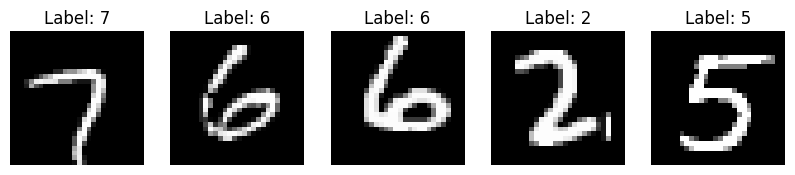

In [ ]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

# Fonction pour charger les données MNIST
def load_mnist_data(train=True):
    transform = transforms.Compose([transforms.ToTensor()])
    mnist_dataset = torchvision.datasets.MNIST(root='./data', train=train, download=True, transform=transform)
    return torch.utils.data.DataLoader(dataset=mnist_dataset, batch_size=5, shuffle=True)

# Charger l'ensemble d'entraînement
train_loader = load_mnist_data(train=True)

# Afficher quelques exemples d'images
for images, labels in train_loader:
    # Afficher les images
    plt.figure(figsize=(10, 2))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i][0], cmap='gray')
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')

    plt.show()
    break  # Stop après le premier lot pour éviter une sortie trop longue


In [ ]:
# Convert data to PyTorch tensors
train_images = torch.FloatTensor(train_images) / 255.0

# Flatten the images
train_images = train_images.view(train_images.size(0), -1)

# Create DataLoader
train_dataset = TensorDataset(train_images, train_images)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# Create DataLoader for test set
test_dataset = TensorDataset(test_images, test_images)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)




In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from timeit import default_timer as timer

# Define the AE class
class AE(nn.Module):

    def __init__(self):
        super().__init__()

        # Encoder
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True),
            nn.Flatten(start_dim=1),
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, 2)
        )

        # Decoder
        self.decoder_cnn = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True),
            nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        # Reshape input to [batch_size, 1, 28, 28]
        x = x.view(-1, 1, 28, 28)

        x = self.encoder_cnn(x)
        x = self.decoder_cnn(x)
        x = torch.sigmoid(x)
        return x



In [ ]:
# Function for training the autoencoder
def train_autoencoder(model: nn.Module, epochs: int = 30, learning_rate: float = 0.004, batch_size: int = 32, save_model: bool = True):
    # Get training and validation set
    train_loader, test_loader = get_data_loaders(batch_size)

    # Setup loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    start_time = timer()

    # Loop for a number of epochs
    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = 0
        validation_loss = 0

        for features, _ in train_loader:
            # Forward pass
            decoded_image = model(features.view(features.size(0), -1))

            # Evaluate loss
            loss = criterion(decoded_image, features)
            train_loss += loss.item()

            optimizer.zero_grad()

            # Backward pass
            loss.backward()

            # Update model weights
            optimizer.step()

        # Print epoch training loss
        print(f'Epoch {epoch} : Training loss {train_loss / len(train_loader)}')
        model.eval()

        with torch.no_grad():
            for features, _ in test_loader:
                # Do the forward pass
                decoded_image = model(features.view(features.size(0), -1))

                loss = criterion(decoded_image, features)
                validation_loss += loss.item()

        print(f'Epoch {epoch} : Validation loss {validation_loss / len(test_loader)}')

    end_time = timer()

    print(f'Total training time: {end_time - start_time:.3f} seconds')

    if save_model:
        # Save the model
        torch.save(model.state_dict(), 'autoencoder_model.pth')
        print(f'Model saved!')

# Function to load MNIST data and create data loaders
def get_data_loaders(batch_size: int = 64):
    transform = transforms.Compose([transforms.ToTensor()])
    mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    # Split the dataset into training and testing sets
    train_size = int(0.8 * len(mnist_dataset))
    test_size = len(mnist_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(mnist_dataset, [train_size, test_size])

    # Create data loaders
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Initialize the autoencoder and train
autoencoder = AE()
train_autoencoder(autoencoder, epochs=30, learning_rate=0.004, batch_size=64, save_model=True)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0 : Training loss 0.20863776073853174


  3%|▎         | 1/30 [00:22<10:38, 22.02s/it]

Epoch 0 : Validation loss 0.15822167639085588
Epoch 1 : Training loss 0.13517820851008097


  7%|▋         | 2/30 [00:44<10:27, 22.41s/it]

Epoch 1 : Validation loss 0.11870801226889834
Epoch 2 : Training loss 0.10947798942526181


 10%|█         | 3/30 [01:07<10:09, 22.58s/it]

Epoch 2 : Validation loss 0.10231933187931141
Epoch 3 : Training loss 0.09753108870983124


 13%|█▎        | 4/30 [01:29<09:39, 22.29s/it]

Epoch 3 : Validation loss 0.0936602105961201
Epoch 4 : Training loss 0.09083411650856336


 17%|█▋        | 5/30 [01:52<09:21, 22.47s/it]

Epoch 4 : Validation loss 0.08850989344113684
Epoch 5 : Training loss 0.08668144899606704


 20%|██        | 6/30 [02:14<09:01, 22.55s/it]

Epoch 5 : Validation loss 0.08514126394181809
Epoch 6 : Training loss 0.08384114272395769


 23%|██▎       | 7/30 [02:36<08:35, 22.42s/it]

Epoch 6 : Validation loss 0.08271226920980088
Epoch 7 : Training loss 0.08169138953089713


 27%|██▋       | 8/30 [03:00<08:24, 22.92s/it]

Epoch 7 : Validation loss 0.08080885880329508
Epoch 8 : Training loss 0.08000156128406524


 30%|███       | 9/30 [03:23<08:01, 22.93s/it]

Epoch 8 : Validation loss 0.07929165740596487
Epoch 9 : Training loss 0.07862181668480238


 33%|███▎      | 10/30 [03:46<07:37, 22.88s/it]

Epoch 9 : Validation loss 0.07802902613865569
Epoch 10 : Training loss 0.07746768732865651


 37%|███▋      | 11/30 [04:08<07:09, 22.59s/it]

Epoch 10 : Validation loss 0.07695216479453634
Epoch 11 : Training loss 0.07644757544000944


 40%|████      | 12/30 [04:31<06:46, 22.56s/it]

Epoch 11 : Validation loss 0.07598218797369206
Epoch 12 : Training loss 0.07553916256626447


 43%|████▎     | 13/30 [04:53<06:24, 22.61s/it]

Epoch 12 : Validation loss 0.07511374992417529
Epoch 13 : Training loss 0.07470495583613714


 47%|████▋     | 14/30 [05:16<06:00, 22.53s/it]

Epoch 13 : Validation loss 0.07430341051138462
Epoch 14 : Training loss 0.07391668776671091


 50%|█████     | 15/30 [05:38<05:35, 22.39s/it]

Epoch 14 : Validation loss 0.07352889099336685
Epoch 15 : Training loss 0.07313840615749359


 53%|█████▎    | 16/30 [06:00<05:14, 22.47s/it]

Epoch 15 : Validation loss 0.07274172732487638
Epoch 16 : Training loss 0.0723655107319355


 57%|█████▋    | 17/30 [06:23<04:53, 22.55s/it]

Epoch 16 : Validation loss 0.07198544904748176
Epoch 17 : Training loss 0.07160935840010643


 60%|██████    | 18/30 [06:45<04:27, 22.29s/it]

Epoch 17 : Validation loss 0.07123306833524654
Epoch 18 : Training loss 0.07084553705652555


 63%|██████▎   | 19/30 [07:08<04:06, 22.42s/it]

Epoch 18 : Validation loss 0.07046293047197322
Epoch 19 : Training loss 0.07005638597408931


 67%|██████▋   | 20/30 [07:30<03:45, 22.54s/it]

Epoch 19 : Validation loss 0.06963807713002601
Epoch 20 : Training loss 0.0692334212064743


 70%|███████   | 21/30 [07:52<03:20, 22.32s/it]

Epoch 20 : Validation loss 0.06880164879592175
Epoch 21 : Training loss 0.06839566801985104


 73%|███████▎  | 22/30 [08:15<02:59, 22.39s/it]

Epoch 21 : Validation loss 0.06797414823891
Epoch 22 : Training loss 0.06756893329819043


 77%|███████▋  | 23/30 [08:37<02:37, 22.47s/it]

Epoch 22 : Validation loss 0.06713838391798607
Epoch 23 : Training loss 0.06676373825470606


 80%|████████  | 24/30 [09:00<02:15, 22.66s/it]

Epoch 23 : Validation loss 0.06638562120497227
Epoch 24 : Training loss 0.06602119516332944


 83%|████████▎ | 25/30 [09:23<01:52, 22.53s/it]

Epoch 24 : Validation loss 0.06565248867140171
Epoch 25 : Training loss 0.0653315820991993


 87%|████████▋ | 26/30 [09:46<01:30, 22.71s/it]

Epoch 25 : Validation loss 0.06500476539293502
Epoch 26 : Training loss 0.06470512396593889


 90%|█████████ | 27/30 [10:09<01:08, 22.86s/it]

Epoch 26 : Validation loss 0.06438165805996099
Epoch 27 : Training loss 0.06412835376461347


 93%|█████████▎| 28/30 [10:32<00:45, 22.78s/it]

Epoch 27 : Validation loss 0.06382703071737543
Epoch 28 : Training loss 0.06359862019618352


 97%|█████████▋| 29/30 [10:55<00:22, 22.80s/it]

Epoch 28 : Validation loss 0.06330869810536821
Epoch 29 : Training loss 0.0631178236057361


100%|██████████| 30/30 [11:20<00:00, 22.69s/it]

Epoch 29 : Validation loss 0.06289211567491293
Total training time: 680.771 seconds
Model saved!


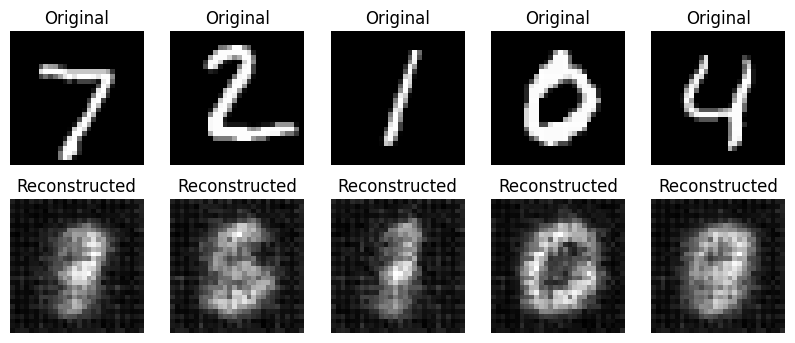

Test Loss: 0.058487605303525925


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def test_and_visualize(model, test_loader):
    model.eval()

    # Get some test images
    images, _ = next(iter(test_loader))

    # Perform the forward pass
    with torch.no_grad():
        reconstructed_images = model(images.view(images.size(0), -1))

    # Calculate the loss
    criterion = torch.nn.MSELoss()
    loss = criterion(reconstructed_images.view_as(images), images)

    # Convert images to NumPy arrays
    images_np = images.cpu().numpy().reshape(-1, 28, 28)
    reconstructed_np = reconstructed_images.cpu().numpy().reshape(-1, 28, 28)

    # Plot the original and reconstructed images
    plt.figure(figsize=(10, 4))
    for i in range(5):
        # Original image
        plt.subplot(2, 5, i + 1)
        plt.imshow(images_np[i], cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Reconstructed image
        plt.subplot(2, 5, i + 6)
        plt.imshow(reconstructed_np[i], cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')

    plt.show()

    return loss.item()

# Call the function to test and visualize
test_loss = test_and_visualize(autoencoder, test_loader)
print(f"Test Loss: {test_loss}")


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
from torchvision import transforms
import torchvision

# Votre classe Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dims, 128)
        self.fc2 = nn.Linear(128, 784)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Votre classe VariationalEncoder
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() if torch.cuda.is_available() else self.N.loc
        self.N.scale = self.N.scale.cuda() if torch.cuda.is_available() else self.N.scale
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu = self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

# Classe VariationalAutoencoder complète
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# Fonction d'entraînement
def train(autoencoder, data, epochs=20, device='cuda' if torch.cuda.is_available() else 'cpu'):
    opt = torch.optim.Adam(autoencoder.parameters())
    autoencoder.to(device)

    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device)
            x = x.view(x.size(0), -1)  # Redimensionner les images
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()

    return autoencoder

# Fonction pour charger les données MNIST
def load_mnist_data(train=True):
    transform = transforms.Compose([transforms.ToTensor()])
    mnist_dataset = torchvision.datasets.MNIST(root='./data', train=train, download=True, transform=transform)
    return torch.utils.data.DataLoader(dataset=mnist_dataset, batch_size=64, shuffle=True)

# Charger l'ensemble d'entraînement
train_loader = load_mnist_data(train=True)

# Redimensionner les images
def resize_images(images):
    return images.view(images.size(0), -1)

# Appliquer le redimensionnement aux données d'entraînement
train_loader.dataset.data = resize_images(train_loader.dataset.data)

# Initialiser et entraîner l'autoencodeur
latent_dimensions = 2
autoencoderV = VariationalAutoencoder(latent_dimensions)
autoencoderV = train(autoencoderV, train_loader, epochs=20)


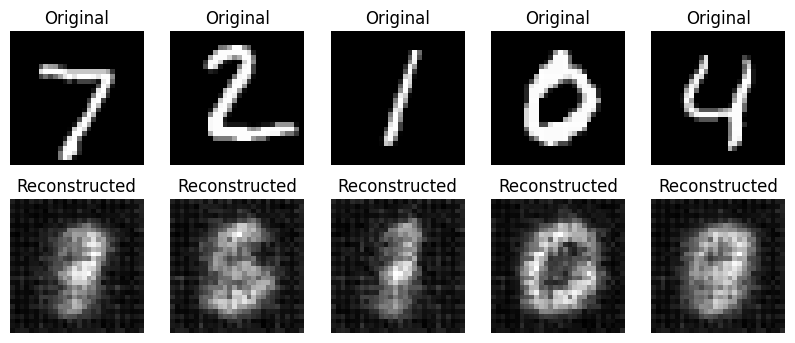

Test Loss: 0.058487605303525925


In [ ]:
def test_and_visualize(model, test_loader):
    model.eval()

    # Obtenir quelques images de test
    images, _ = next(iter(test_loader))

    # Effectuer la passe avant
    with torch.no_grad():
        reconstructed_images = model(images.view(images.size(0), -1))

    # Calculer la perte
    criterion = torch.nn.MSELoss()
    loss = criterion(reconstructed_images.view_as(images), images)

    # Convertir les images en tableaux NumPy
    images_np = images.cpu().numpy().reshape(-1, 28, 28)
    reconstructed_np = reconstructed_images.cpu().numpy().reshape(-1, 28, 28)

    # Tracer les images originales et reconstruites
    plt.figure(figsize=(10, 4))
    for i in range(5):
        # Image originale
        plt.subplot(2, 5, i + 1)
        plt.imshow(images_np[i], cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Image reconstruite
        plt.subplot(2, 5, i + 6)
        plt.imshow(reconstructed_np[i], cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')

    plt.show()

    print(f"Test Loss: {loss.item()}")

# Utiliser la fonction de test et de visualisation
test_and_visualize(autoencoder, test_loader)


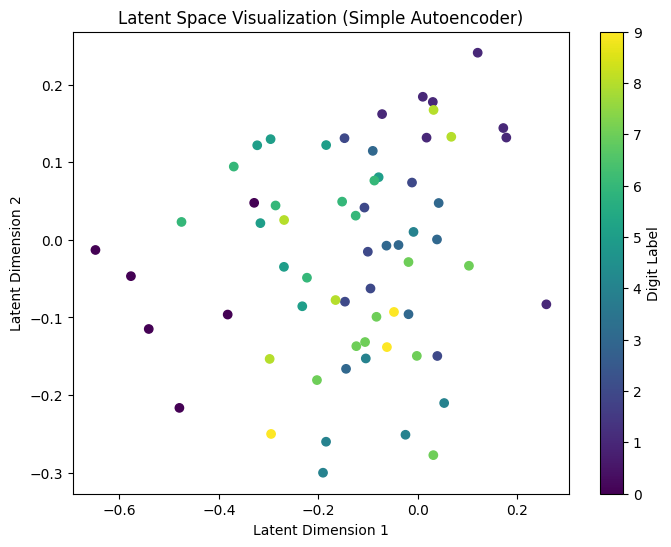

In [ ]:
def visualize_latent_space_simple_autoencoder(model, data_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.eval()
    data_iterator = iter(data_loader)

    # Get the entire dataset
    images, labels = next(data_iterator)
    images = images.to(device)

    # Encode the images to obtain the latent space representation
    with torch.no_grad():
        latent_space = model.encoder_cnn(images.view(images.size(0), 1, 28, 28)).cpu().numpy()

    # Plot the latent space
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_space[:, 0], latent_space[:, 1], c=labels.numpy(), cmap='viridis')
    plt.colorbar(scatter, label='Digit Label')
    plt.title('Latent Space Visualization (Simple Autoencoder)')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()

# Visualize the latent space for the simple autoencoder
visualize_latent_space_simple_autoencoder(autoencoder, train_loader)


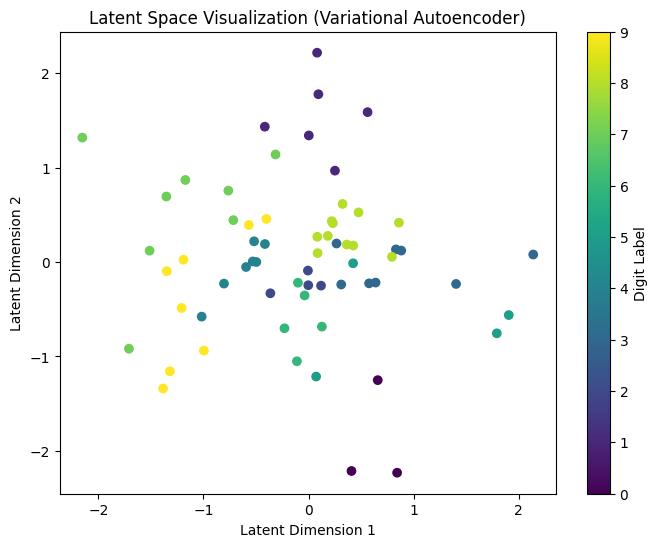

In [ ]:
def visualize_latent_space_variational_autoencoder(model, data_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.eval()
    data_iterator = iter(data_loader)

    # Get the entire dataset
    images, labels = next(data_iterator)
    images = images.to(device)

    # Encode the images to obtain the latent space representation
    with torch.no_grad():
        latent_space = model.encoder(images.view(images.size(0), 1, 28, 28)).cpu().numpy()

    # Plot the latent space
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_space[:, 0], latent_space[:, 1], c=labels.numpy(), cmap='viridis')
    plt.colorbar(scatter, label='Digit Label')
    plt.title('Latent Space Visualization (Variational Autoencoder)')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()

# Visualize the latent space for the variational autoencoder
visualize_latent_space_variational_autoencoder(autoencoderV, train_loader)
